# 4square_channel

## 5. 4square_channel.png Four square = imagery, surface, bed&surface, change

### Datapaper plots

1. field_location.png Modis moa Inset map, ant in corner, icestreams scale, square of common border, include flow route,
2. geophysics_overview.png Map of all data presented
3. historic_channel.png Historic landsat images
4. thickness_surfacecolour.png Profile depth
6. 3D view of channel
7. radarlines 
8. channel_meander.png meander
11. ApRES include stress
9. Icesat1/REMA
10. Icesat2


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points
from rasterio.windows import Window
import string
import matplotlib.gridspec as gridspec
import pickle

In [26]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

In [27]:
#load REMA demfocussing on
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)
    
x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

x_i = np.argwhere((x>xmin) & (x< xmax)).flatten()[0]
x_j = np.argwhere((x>xmin) & (x< xmax)).flatten()[-1]
y_i = np.argwhere((y>ymin) & (y< ymax)).flatten()[0]
y_j = np.argwhere((y>ymin) & (y< ymax)).flatten()[-1]

x_c = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')[x_i:x_j]
y_c = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')[y_i:y_j]

xv_REMA, yv_REMA = np.meshgrid(x_c, y_c)

im_REMA_d = im_REMA[y_i:y_j,x_i:x_j]
im_REMA_d[im_REMA_d==-99.99] = np.nan
im_REMA_c = im_REMA_d

In [28]:
im_REMA[im_REMA!=-9999.0].mean()

67.36358

In [29]:
# im_REMAdiff[np.abs(im_REMAdiff)>50]=np.nan

In [30]:
# # Load ice base interpolated from radar results
# direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

# xv = np.load(direc + 'x_grid' +'.npy')
# yv = np.load(direc + 'y_grid' +'.npy')
# thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
# extent_l2l = np.load(direc +'extent.npy')
# ice_base = np.load(direc +'_ice_base.npy')
# ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

# ice_base.shape

In [31]:
# Load ice base interpolated from radar results
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_gridded_'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickn.npy')
extent_l2l = np.load(direc +'extent.npy')
ice_base = np.load(direc +'ice_base.npy')
ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

In [34]:
np.diff(xv[0,:])
np.diff(yv[:,0])

array([-2, -2, -2, ..., -2, -2, -2])

In [8]:
gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')
cross_channel_lines = ['line7p75','line7p5','line7p25','line7', 'line6','line5','lineAPREScross','line4','line3','line2','line1','line0']

In [9]:
gpr = gpr[gpr.camp=='KIS2'].copy()

In [10]:
#smooth REMA dem for contours
im_REMA_c_smoo = sp.ndimage.gaussian_filter(im_REMA_c, sigma=20, order=0)
del im_REMA_d,im_REMA_c

In [11]:
# # get icesat2 diff lines
# import sys
# sys.path.append('/Users/home/whitefar/DATA/code/REMOTE_SENSING/ICESAT/')
# from cross_channel import icesat_dataset
# ds = icesat_dataset("/Volumes/arc_02/REMOTE_SENSING/ICESAT2/ATLAS/ATLXI/ds_subkamb_20201111.nc")
# ds.getdata_dhdt(cycle_number_from=3,cycle_number_till=8)
# ds.dadh.query(f'x>{xmin} & x<{xmax} & y<{ymax} & y>{ymin}',inplace=True)

# historic

In [12]:
gdf_hist = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/cresisplus1516Channel.shp').rename(columns={'field_1':'x','field_2':'y','field_3':'surf','field_4':'bed'})

In [13]:
gdf_hist

x               y           surf             bed  \
0      -3.6318213e+05  -7.2185341e+05  3.2990133e+01  -6.0398785e+02   
1      -3.6319282e+05  -7.2186369e+05  3.2947631e+01  -6.0391456e+02   
2      -3.6320309e+05  -7.2187377e+05  3.2908635e+01  -6.0395704e+02   
3      -3.6321357e+05  -7.2188429e+05  3.2860100e+01  -6.0408284e+02   
4      -3.6322378e+05  -7.2189477e+05  3.2805436e+01  -6.0420472e+02   
...               ...             ...            ...             ...   
28107  -3.7491400e+05  -7.3007800e+05  2.8726000e+01  -5.1545400e+02   
28108  -3.7491400e+05  -7.3007800e+05  2.8726000e+01  -5.1545400e+02   
28109  -3.7491400e+05  -7.3007800e+05  2.8726000e+01  -5.1545400e+02   
28110  -3.7491400e+05  -7.3007800e+05  2.8726000e+01  -5.1545400e+02   
28111  -3.7491400e+05  -7.3007800e+05  2.8726000e+01  -5.1545400e+02   

                                       geometry  
0      POINT Z (-363182.130 -721853.410 32.990)  
1      POINT Z (-363192.820 -721863.690 32.948)  
2      POINT Z (-363203.090 -721873.770 32.909)  
3      POINT Z (-363213.570 -721884.290 32.860)  
4      POINT Z (-363223.780 -721894.770 32.805)  
...                                         ...  
28107  POINT Z (-374914.000 -730078.000 28.726)  
28108  POINT Z (-374914.000 -730078.000 28.726)  
28109  POINT Z (-374914.000 -730078.000 28.726)  
28110  POINT Z (-374914.000 -730078.000 28.726)  
28111  POINT Z (-374914.000 -730078.000 28.726)  

[28112 rows x 5 columns]

In [14]:
gdf_hist.shape

(28112, 5)

In [15]:
gdf_hist = gdf_hist.astype({'x':'float','y':'float','surf':'float','bed':'float'}).copy()

In [16]:
gdf_hist['ice_thickn'] = gdf_hist.surf - gdf_hist.bed

In [17]:

gdf_hist.query("x > -382700 & x < -374781.9 & y > -734075.1 & y < -721770.2",inplace=True)

In [18]:
yticks = (np.linspace(-734000,-722000,4)/1000).astype(int)
xticks = (np.linspace(-382000,-376000,4)/1000).astype(int)

In [19]:
xmin, xmax, ymin, ymax = -382700/1000, -374781.9/1000, -734075.1/1000, -721770.2/1000

In [20]:
gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')
cross_channel_lines = ['line7p75','line7p5','line7p25','line7', 'line6','line5','lineAPREScross','line4','line3','line2','line1','line0']

gpr = gpr[gpr.camp=='KIS2'].copy()

In [21]:
gdf_hist.x.shape

(6202,)

# plot it

In [22]:
with open('/Users/home/whitefar/DATA/global_corrections.pkl',"rb") as f2:
    correct = pickle.load(f2)
geoid_correction = correct['geoid_correction']
res_correction = correct['res_correction']
apres_firn = correct['apres_firn']

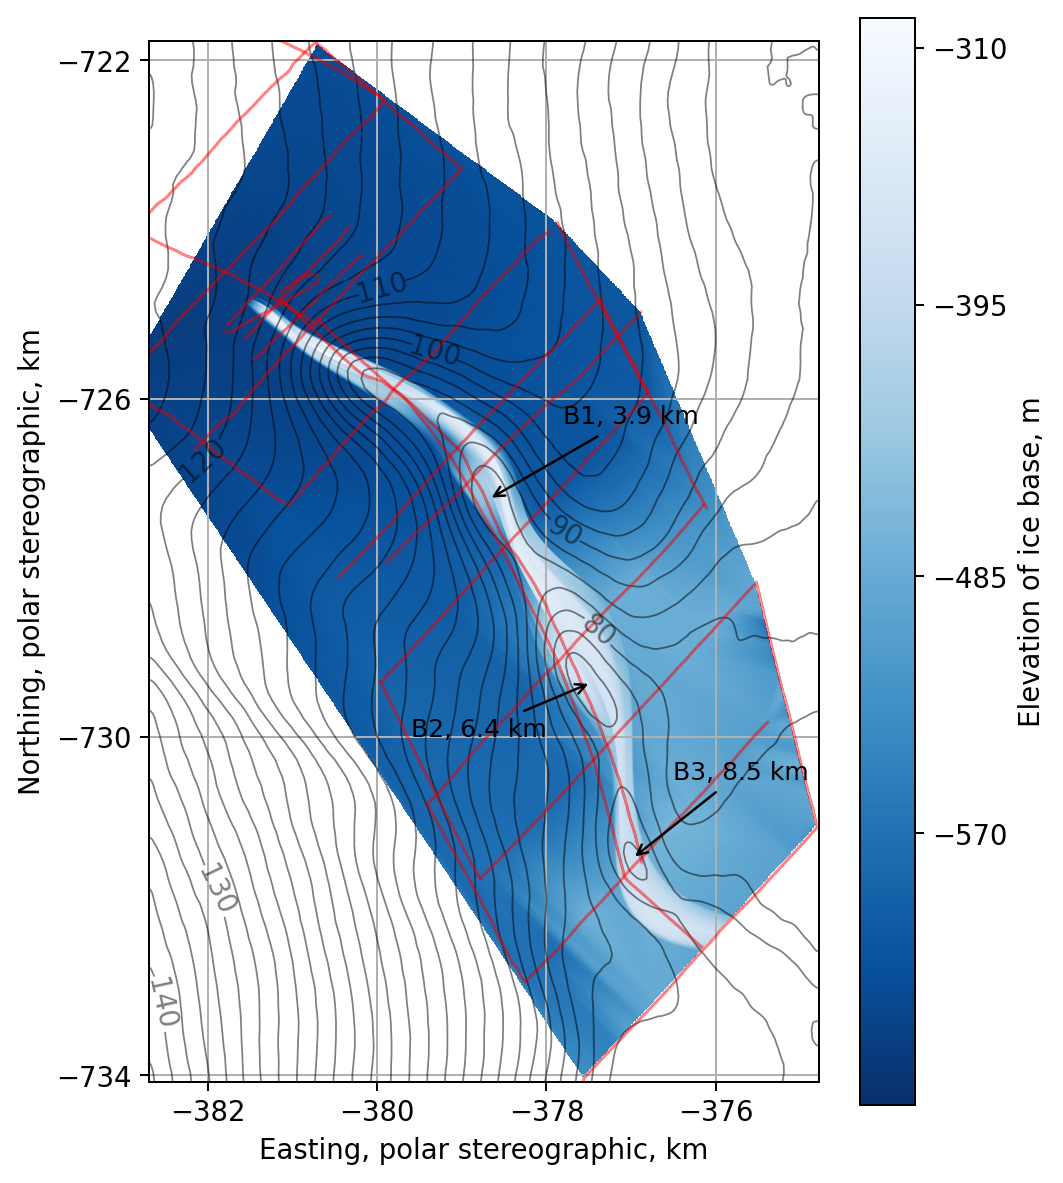

In [24]:
plt.figure( dpi=180,figsize=(6,8))

plt.rcParams.update({'font.size': 11})


# #C base with surface contours
samp = 50
CS =  plt.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp]+geoid_correction,
                      30,vmin=15+geoid_correction,vmax=90+geoid_correction, 
#                   cmap='BrBG',
                  colors='black',
                  alpha=0.5,linewidths=0.7)
plt.clabel(CS,CS.levels[0::4], inline=1,  fmt='%i')


plt.imshow(ice_base+geoid_correction+res_correction,extent=np.array(extent_l2l)/1000,cmap='Blues_r',vmin=-700+geoid_correction+res_correction,vmax=-340+geoid_correction+res_correction)
cb3 = plt.colorbar()
cb3.set_label('Elevation of ice base, m')
cb3.set_ticks(np.round(np.linspace(-350+geoid_correction + res_correction,-700+geoid_correction + res_correction,5)/5)*5)

plt.plot(gpr.x/1000,gpr.y/1000,'r.',label='radar profiles',markersize=0.05)

# plt.scatter(gdf_hist.x/1000,gdf_hist.y/1000,c=gdf_hist.bed,cmap='Blues_r',s=2)

plt.annotate( 'B1, 3.9 km',(-378.7, -727.2),xytext=(-378.8+1, -727.3+1),arrowprops=dict(arrowstyle='->'),fontsize=10)
plt.annotate( 'B2, 6.4 km',(-377.45, -729.35),xytext=(-377.6-2, -729.5-0.5),arrowprops=dict(arrowstyle='->'),fontsize=10)
plt.annotate( 'B3, 8.5 km',(-377.0, -731.45),xytext=(-377.5+1, -731.5+1),arrowprops=dict(arrowstyle='->'),fontsize=10)



plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Easting, polar stereographic, km')
plt.ylabel('Northing, polar stereographic, km')

# plt.text( -378.6,-722.5, 'IB',size=10)

# plt.text( -376.7,-722.5, 'IB',size=10)
plt.grid()

plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/ice_base_solo.png')

##############################

plt.show()
#

In [25]:
ib_smoo = sp.ndimage.gaussian_filter(ice_base+geoid_correction+res_correction, sigma=100)

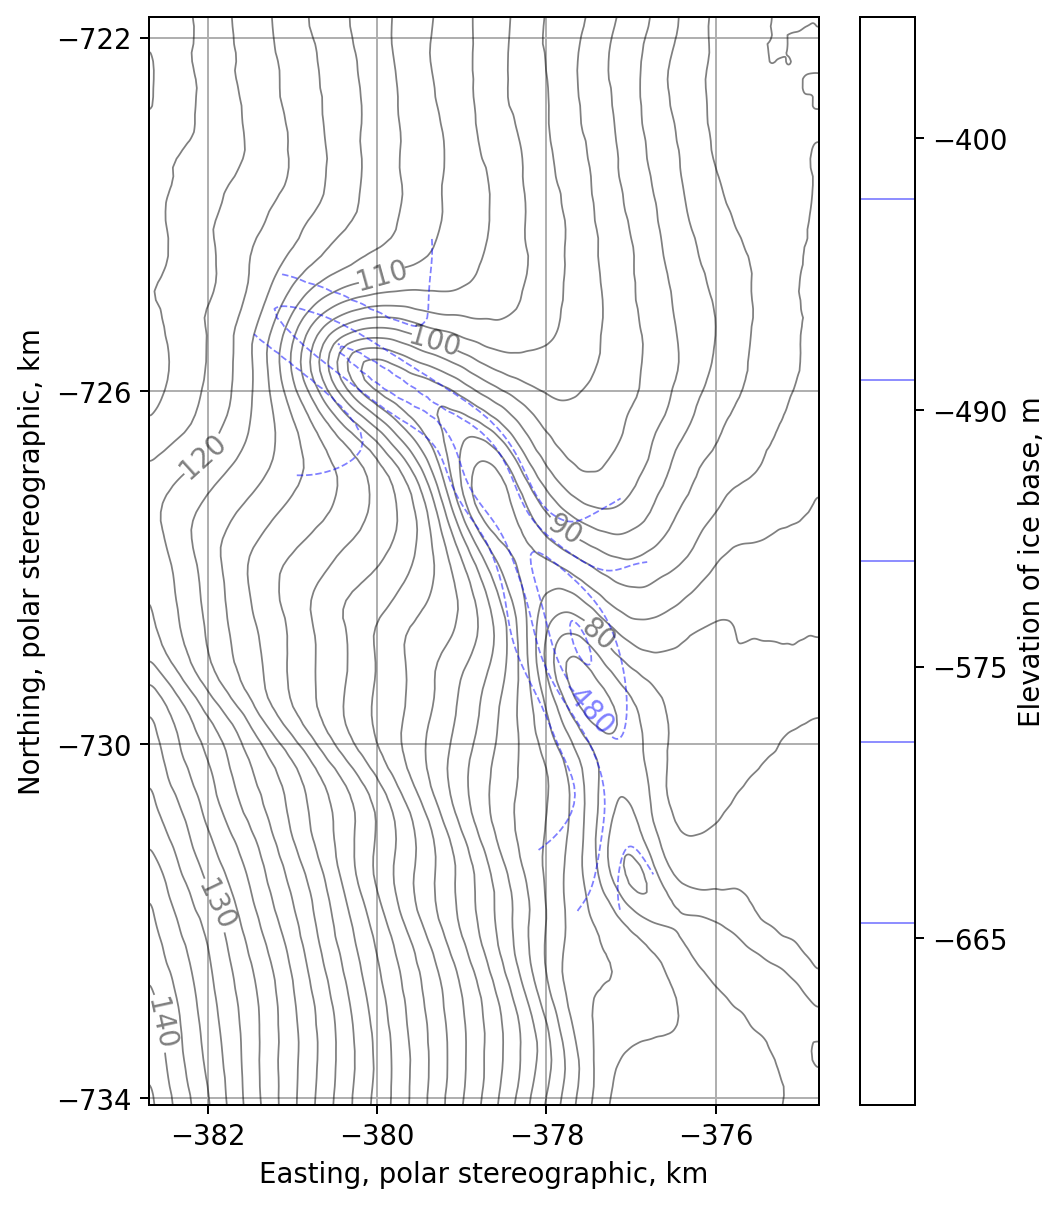

In [28]:
plt.figure( dpi=180,figsize=(6,8))

plt.rcParams.update({'font.size': 11})


# #C base with surface contours
samp = 50
CS =  plt.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp]+geoid_correction,
                      30,vmin=15+geoid_correction,vmax=90+geoid_correction, 
#                   cmap='BrBG',
                  colors='black',
                  alpha=0.5,linewidths=0.7)
plt.clabel(CS,CS.levels[0::4], inline=1,  fmt='%i')

CCS =  plt.contour(xv[::samp]/1000,
                   yv[::samp]/1000,
                   ib_smoo[::samp],
                      4,vmin=15+geoid_correction,vmax=90+geoid_correction, 
#                   cmap='BrBG',
                  colors='blue',
                  alpha=0.5,linewidths=0.7)
plt.clabel(CCS,CCS.levels[0::4], inline=1,  fmt='%i')

# plt.imshow(sp.ndimage.gaussian_filter(ice_base+geoid_correction+res_correction, sigma=100),extent=np.array(extent_l2l)/1000,cmap='Blues_r',vmin=-700+geoid_correction+res_correction,vmax=-340+geoid_correction+res_correction)
cb3 = plt.colorbar()
cb3.set_label('Elevation of ice base, m')
cb3.set_ticks(np.round(np.linspace(-350+geoid_correction+res_correction,-700+geoid_correction+res_correction,5)/5)*5)



plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Easting, polar stereographic, km')
plt.ylabel('Northing, polar stereographic, km')

# plt.text( -378.6,-722.5, 'IB',size=10)

# plt.text( -376.7,-722.5, 'IB',size=10)
plt.grid()



##############################

plt.show()
#

In [42]:
'%.2f' % (1.323)

'1.32'

In [22]:
# https://stackoverflow.com/questions/51446526/plt-subplot-adjust-not-working-correctly

# contour only

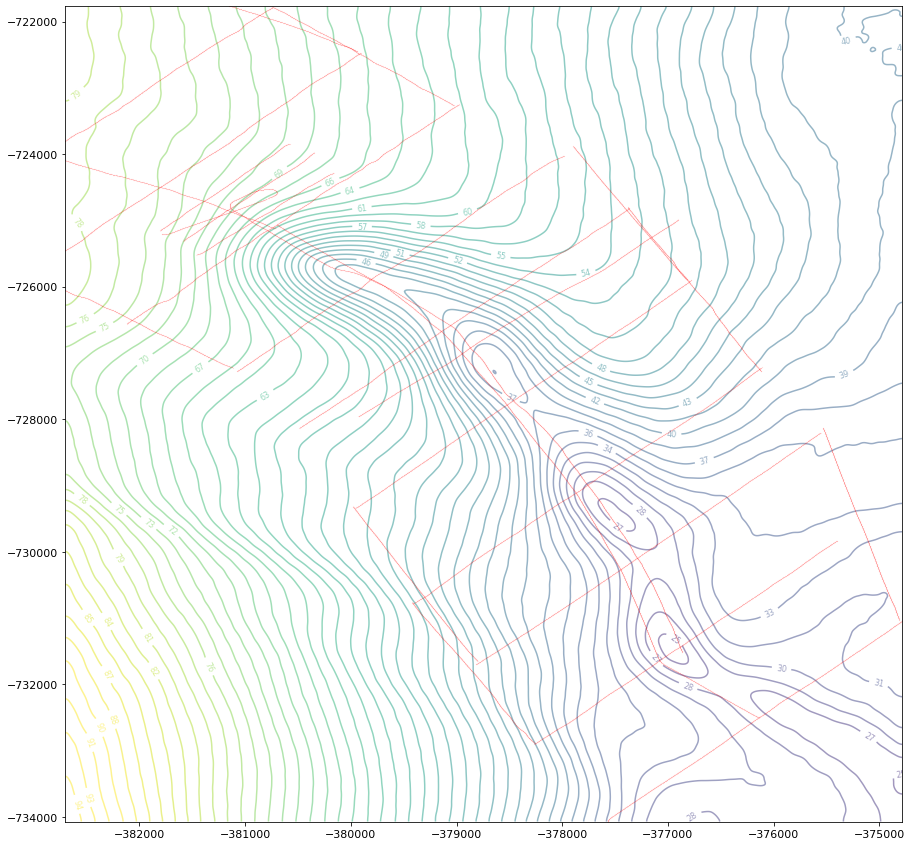

In [26]:
plt.figure(figsize=(15,15))
# fig.subplots_adjust(hspace=0.2, wspace=-0.3)

samp = 10

CS =  plt.contour(xv_REMA[::samp],yv_REMA[::samp],im_REMA_c_smoo[::samp],
                      50,vmin=15,vmax=90, alpha=0.5)
plt.clabel(CS, inline=1, fontsize=8, fmt='%i')
plt.plot(gpr.x,gpr.y,'r.',label='radar profiles',markersize=0.05)


# plt.imshow(im_REMA,extent=extent_REMA,vmin=15,vmax=90, cmap='BrBG')
# plt.grid()
plt.xlim([xmin*1000,xmax*1000])
plt.ylim([ymin*1000,ymax*1000])
# plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)



# cb1 = fig.colorbar(a1,ax=plt)
# cb1.label('elevation,')
# cb1.ticks(np.round(np.linspace(15,90,5)/5)*5)



plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'flat'

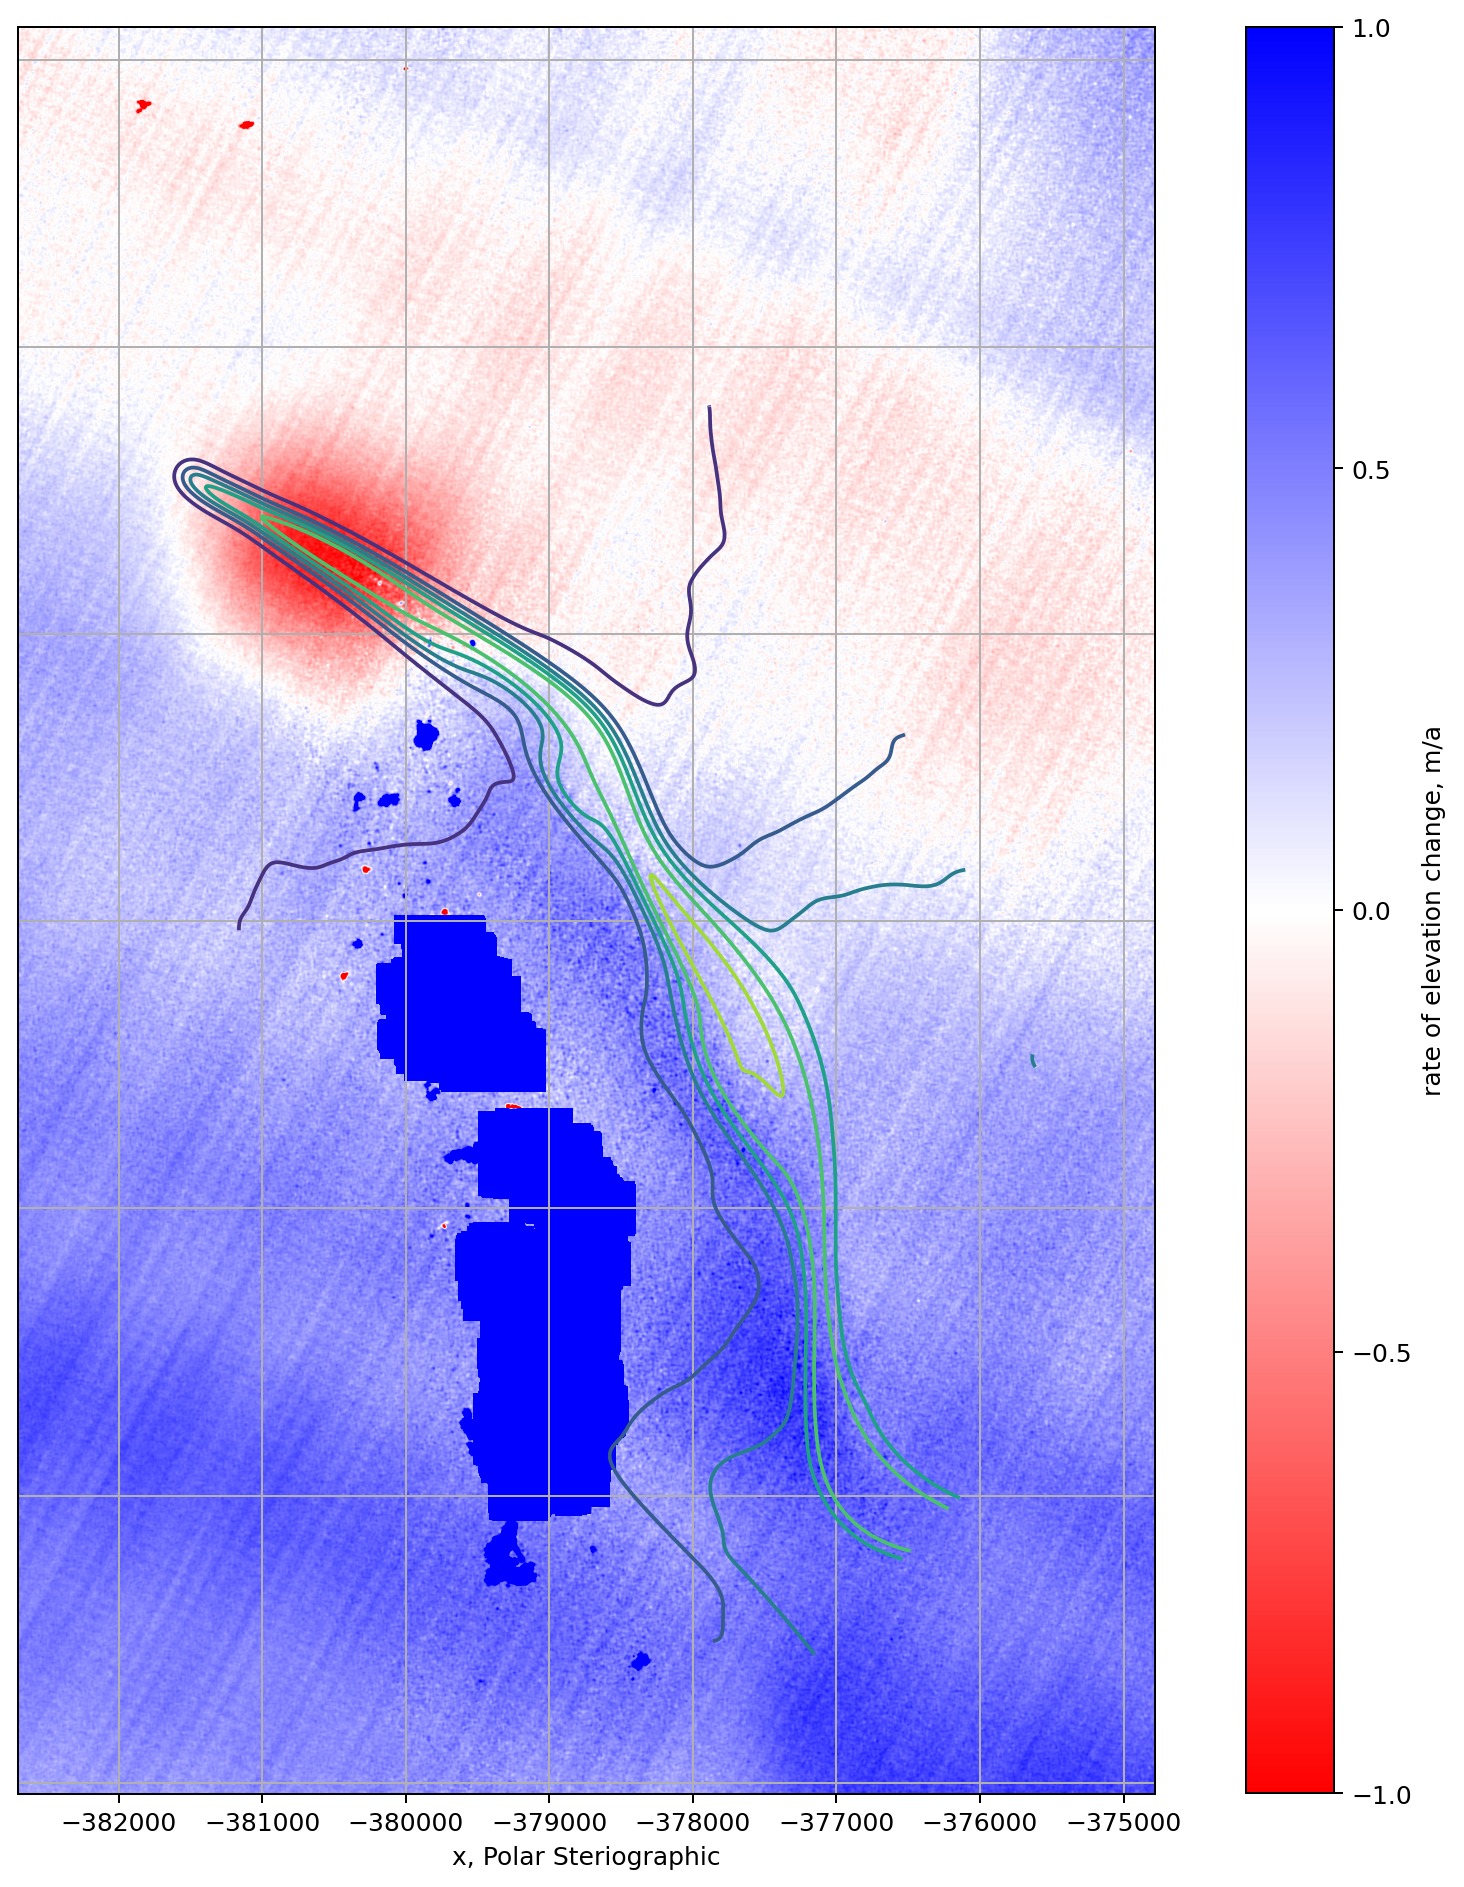

In [14]:
fig, ax = plt.subplots(1,1, dpi=180,figsize=(13,13))
# fig.subplots_adjust(hspace=0.2, wspace=-0.3)

# #

# #D rate of change of surf
CS4 =  ax.contour(xv[:,500:],yv[:,500:],ice_base_smooth[:,500:],np.arange(-700,-300,50))
# ax.clabel(CS4, inline=1, fontsize=8, fmt='%i')
ax.tick_params(left=False, labelleft=False)

im4 = ax.imshow(-im_REMAdiff,extent=extent_REMAdiff, vmin=-1,vmax=1,cmap='bwr_r')
# ax.scatter(ds.dadh.x,ds.dadh.y,c=ds.dadh.dhdt,cmap='bwr_r',vmin=-0.8, vmax=1)
ax.grid()
ax.xlim([xmin,xmax])
ax.ylim([ymin,ymax])


cb4 = fig.colorbar(im4,ax=ax)
cb4.label('rate of elevation change, m/a')
cb4.ticks(np.linspace(-1,1,5))
ax.xlabel('x, Polar Steriographic')


#write A B C D from a loop
axs = ax.flat
for n, a in enumerate(axs):
    a.text(-0.1, 1.05, string.ascii_uppercase[n], transform=a.transAxes, 
            size=20, weight='bold')

# plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/4square_channel.png')
# 
##############################

plt.show()
#

In [ ]:
# calculate surface gradient

In [29]:
dist = 1470
height = 25.5
angle = np.arctan(height/dist)

In [30]:
np.degrees(angle)

0.9938067030994084

In [33]:
(height/dist)*100

1.7346938775510203